<a href="https://colab.research.google.com/github/wangxioanke/deep-learning-notebook/blob/main/%E8%AF%86%E5%88%AB%E7%83%AD%E7%8B%97%E6%9C%80%E6%96%B0%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.7.0


In [ ]:
cd /content/sample_data

/content/sample_data


**图像增广系列函数**

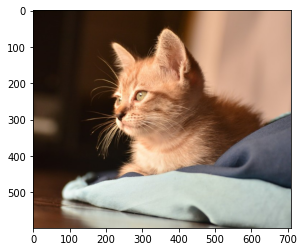

In [ ]:
from matplotlib import pyplot as plt

img = plt.imread('cat.jpg')
plt.imshow(img)

**左右翻转**

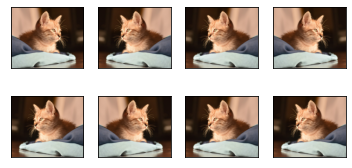

In [ ]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

apply(img, tf.image.random_flip_left_right)

**上下翻转**

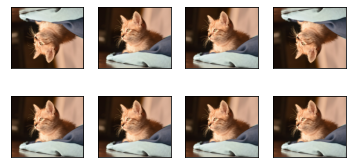

In [ ]:
apply(img, tf.image.random_flip_up_down)

**随机采样面积，避免模型对位置的敏感度**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c0383b590>,
      dtype=object)

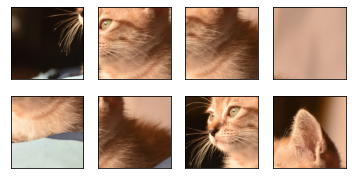

In [ ]:
aug=tf.image.random_crop
num_rows=2
num_cols=4
scale=1.5
crop_size=200

Y = [aug(img, (crop_size, crop_size, 3)) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)

**变换光亮**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c035fa990>,
      dtype=object)

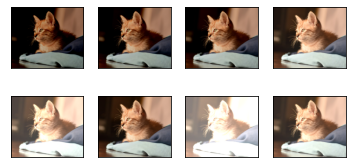

In [ ]:
aug=tf.image.random_brightness
num_rows=2
num_cols=4
scale=1.5
max_delta=0.5

Y = [aug(img, max_delta) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)

**变换色彩**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c033a6fd0>,
      dtype=object)

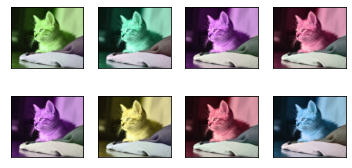

In [ ]:
aug=tf.image.random_hue
num_rows=2
num_cols=4
scale=1.5
max_delta=0.5

Y = [aug(img, max_delta) for _ in range(num_rows * num_cols)]
show_images(Y, num_rows, num_cols, scale)

In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=dad463913b7df243f3899b44da684b585fcd24e0928d2ed1557c9ba760c458a7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import os
import zipfile
import wget


def download_data():
    data = os.getcwd()+'/data'
    base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
    wget.download(
        base_url + 'gluon/dataset/hotdog.zip',
        data)

    with zipfile.ZipFile('data', 'r') as z:
        z.extractall(os.getcwd())

download_data()

In [4]:
import pathlib
import numpy as np
import tensorflow as tf
train_dir = 'hotdog/train'
test_dir = 'hotdog/test'
train_dir = pathlib.Path(train_dir)
train_count = len(list(train_dir.glob('*/*.jpg')))
test_dir = pathlib.Path(test_dir)
test_count = len(list(test_dir.glob('*/*.jpg')))

CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != 'LICENSE.txt' and item.name[0] != '.'])
CLASS_NAMES

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_data_gen = image_generator.flow_from_directory(directory=str(train_dir),
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    classes = list(CLASS_NAMES))

test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    classes = list(CLASS_NAMES))

Found 2000 images belonging to 2 classes.
Found 798 images belonging to 2 classes.


In [5]:
print(CLASS_NAMES)

['not-hotdog' 'hotdog']


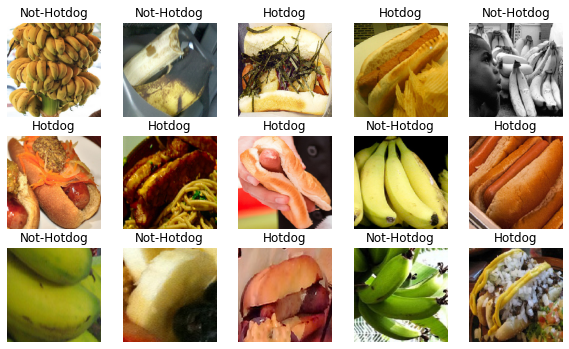

In [6]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')


image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [7]:
# 下载模型
import tensorflow as tf

ResNet50 = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3))
# layer.trainable 设置为 False 会将层的所有权重从可训练移至不可训练。这一过程称为“冻结”层：已冻结层的状态在训练期间不会更新
for layer in ResNet50.layers:
    layer.trainable = False
net = tf.keras.models.Sequential()
net.add(ResNet50)
# 当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本变平（flatten）
net.add(tf.keras.layers.Flatten())

net.add(tf.keras.layers.Dense(2, activation='softmax'))

102883328/102869336 [==============================] - 1s 0us/step


**迁移学习的模型**

In [9]:
net.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = net.fit_generator(
                    train_data_gen,
                    steps_per_epoch=10,
                    epochs=3,
                    validation_data=test_data_gen,
                    validation_steps=10
                    )

net.save("mymodel")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/3
10/10 [==============================] - 81s 8s/step - loss: 0.6826 - accuracy: 0.7500 - val_loss: 0.6777 - val_accuracy: 0.7906
Epoch 2/3
10/10 [==============================] - 76s 8s/step - loss: 0.6757 - accuracy: 0.8156 - val_loss: 0.6731 - val_accuracy: 0.8000
Epoch 3/3
10/10 [==============================] - 77s 8s/step - loss: 0.6687 - accuracy: 0.8313 - val_loss: 0.6670 - val_accuracy: 0.8094
INFO:tensorflow:Assets written to: mymodel/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


**没有进行迁移学习的模型**

In [21]:
ResNet50_scratch = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224,224,3))
net_scratch = tf.keras.models.Sequential()
net_scratch.add(ResNet50_scratch)
net_scratch.add(tf.keras.layers.Flatten())
net_scratch.add(tf.keras.layers.Dense(2, activation='softmax'))

net_scratch.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = net_scratch.fit_generator(
                    train_data_gen,
                    steps_per_epoch=10,
                    epochs=3,
                    validation_data=test_data_gen,
                    validation_steps=10
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/3
10/10 [==============================] - 171s 16s/step - loss: 0.6772 - accuracy: 0.7138 - val_loss: 0.6763 - val_accuracy: 0.7000
Epoch 2/3
10/10 [==============================] - 163s 16s/step - loss: 0.6677 - accuracy: 0.7566 - val_loss: 0.6795 - val_accuracy: 0.7000
Epoch 3/3
10/10 [==============================] - 175s 18s/step - loss: 0.6589 - accuracy: 0.7688 - val_loss: 0.6996 - val_accuracy: 0.5000


In [22]:
from PIL import Image
reconstructed_model = tf.keras.models.load_model("mymodel")

test_dir = "/content/assert"
test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                           batch_size=1,
                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                          shuffle=True,
                          classes = list(CLASS_NAMES))


predict_np = reconstructed_model.predict(test_data_gen) # 不是，是

Found 1 images belonging to 2 classes.


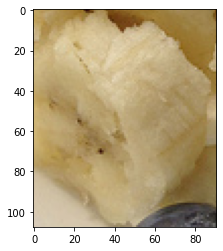

In [23]:
from matplotlib import pyplot as plt

img = plt.imread('/content/assert/not-hotdog/1000.png')
plt.imshow(img)

In [25]:
# 预测函数
if predict_np[0][0]>0.5:
  print("not-hotdog")
else:
  print("hot-dog")

not-hotdog


Found 1 images belonging to 2 classes.
hot-dog


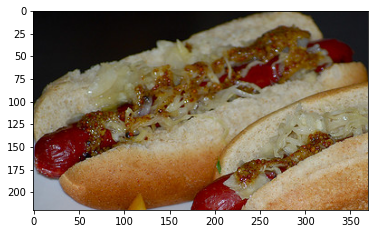

In [28]:
from PIL import Image
reconstructed_model = tf.keras.models.load_model("mymodel")

test_dir = "/content/test"
test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                           batch_size=1,
                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                          shuffle=True,
                          classes = list(CLASS_NAMES))


predict_np = reconstructed_model.predict(test_data_gen)

from matplotlib import pyplot as plt

img = plt.imread('/content/test/hotdog/1020.png')
plt.imshow(img)

# 预测函数
if predict_np[0][0]>0.5:
  print("not-hotdog")
else:
  print("hot-dog")